In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math

In [ ]:
columns = ['Capture_time', 'Id']
print('Reading CSV...')
print(datetime.datetime.now())

data = pd.read_csv('../evo_data_menor.csv', usecols=columns, nrows=30000000)

print(datetime.datetime.now())
print('Finish\n')

Reading CSV...
2018-12-12 07:37:33.592428


In [ ]:
data.head()

In [4]:
# Colleting vehicle ids
car_ids = list(data.Id.unique())

# Removing uncommon ids
# Ex: 4c5865a3-4b03-40f6-a3a8-d4e94aae3b17
ids_uncommon = [id for id in car_ids if id.find('-') != -1]
car_ids = [id for id in car_ids if id.find('-') == -1]

print('Data len before remove uncommon ids: '+str(len(data)))
data = data[~data.Id.isin(ids_uncommon)]
print('Data len after remove uncommon ids: '+str(len(data)))

Data len before remove uncommon ids: 30000000
Data len after remove uncommon ids: 29999500


In [2]:
def str_to_datetime(df_time):
    """ 
    Reformatando de string para datetime.
    
    Parameters
    ----------
    df_time : pandas.DataFrame, string
        Dataframe com strings a serem convertidas para datetime.
    
    Returns
    ----------
    date_list : pandas.DataFrame, datetime
        Dataframe com valores em datetime para possíveis fusos de Vancouver.
    
    """
    date_list = []
    
    # Formatos de fuso horário comum de Vancouver e 
    # fuso horário característico de horário de verão
    format_string = ['%Y-%m-%d %H:%M:%S.%f-08:00', '%Y-%m-%d %H:%M:%S.%f-07:00',
                     '%Y-%m-%d %H:%M:%S-08:00', '%Y-%m-%d %H:%M:%S-07:00']
    
    
    for date in df_time:
        erro = True
        for fmt in format_string:
            try:
                date_list.append(datetime.datetime.strptime(str(date), fmt))
                erro = False
                break
            except:
                pass
        if erro:
            print('Erro in: '+str(date))
            
    
    return pd.DataFrame(date_list)

In [6]:
print('Date strings to Datetime type\n')
data['Capture_time'] = str_to_datetime(data['Capture_time'])

Date strings to Datetime type



In [ ]:
data.head()

,Capture_time,Id
0,2018-03-01 08:24:51.795031,JTDKDTB31J1599606
1,2018-03-01 08:24:51.795031,JTDKDTB31H1597557
2,2018-03-01 08:24:51.795031,JTDKDTB36E1079858
3,2018-03-01 08:24:51.795031,JTDKDTB33F1101042
4,2018-03-01 08:24:51.795031,JTDKDTB32G1118514


In [ ]:
print(datetime.datetime.now())

data = data.sort_values(by='Capture_time')
# Series with each collected minute
dates = pd.Series(data.Capture_time.unique())
busy_weekdays = []
busy_weekends = []

# Going through each date in order to count the number of cars in travel.
for dt in dates:
    parked = len(data[data['Capture_time'] == dt])
    in_travel = len(car_ids) - parked
    percentage = (in_travel/len(car_ids))*100
    
    # Sorting out per week day
    if dt.weekday() <= 4: # Monday == 0 .. Sunday == 6
        busy_weekdays.append([int(dt.timestamp()), in_travel, percentage])
    else: 
        busy_weekends.append([int(dt.timestamp()), in_travel, percentage])
        

dfIn_Travel_weekdays = pd.DataFrame(busy_weekdays, columns=['capture_time', 'total_in_travel', 'percentage'])
dfIn_Travel_weekends = pd.DataFrame(busy_weekends, columns=['capture_time', 'total_in_travel', 'percentage'])

print(datetime.datetime.now())

2018-12-10 14:08:38.509259


In [3]:
def from_timestamp_list(timestamp_list):
    
    datetime_list = []
    
    for date in timestamp_list:
        datetime_list.append(datetime.datetime.fromtimestamp(int(date)))
    
    return pd.DataFrame(datetime_list)

In [73]:
# Formatando os dados de unix timestamp para datetime

dfWeekdays = dfIn_Travel_weekdays

dfWeekdays['capture_time'] = from_timestamp_list(dfWeekdays['capture_time'])    
    
    
dfWeekends = dfIn_Travel_weekends

dfWeekends['capture_time'] = from_timestamp_list(dfWeekends['capture_time'])

In [ ]:
# Plot da porcentagem de carros alocados em dias de semana
plt.plot(dfWeekdays['capture_time'],dfWeekdays['percentage'])
plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
# Plot da porcentagem de carros alocados em dias de final de semana
plt.plot(dfWeekends['capture_time'],dfWeekends['percentage'])
plt.gcf().autofmt_xdate()
plt.show()

In [13]:
dfWeekends.to_csv('weekends.csv', index=False, encoding='utf-8')
dfWeekdays.to_csv('weekdays.csv', index=False, encoding='utf-8')

In [2]:
dfWeekdays = pd.read_csv('../evo-plots/weekdays_dec.csv')
dfWeekends = pd.read_csv('../evo-plots/weekends_dec.csv')

In [3]:
dfWeekdays['capture_time'] = pd.to_datetime(dfWeekdays['capture_time'])
dfWeekends['capture_time'] = pd.to_datetime(dfWeekends['capture_time'])

In [4]:
def media(df):
    # Estrutura de todos os minutos de um dia
    minutes = pd.date_range(start='2016-12-31 00:00:00', end='2016-12-31 23:59:00', freq='min')
    minutos = minutes.time

    # Cria estrutura para contabilizar a quantidade de carros por minuto e 
    # a quantidade daquele minuto que tem carros
    result = {}

    for reg in df.values:
        indice = str(reg[0].hour)+':'+str(reg[0].minute)
        #tem o indice?
        if not indice in result:
            result[indice] = [0,0]

        if (reg[2] > 0):
            result[indice][0] += reg[2]
            result[indice][1] += 1

    # Cria uma estrutura para contabilizar a variância
    desvio = {}

    for reg in df.values:
        indice = str(reg[0].hour)+':'+str(reg[0].minute)
        #tem o indice?
        if not indice in desvio:
            desvio[indice] = 0.0

        if (reg[2] > 0):
            media = result[indice][0]/result[indice][1]
            std = ((reg[2]-media)**2)/result[indice][1]
            desvio[indice] += std


    for reg in desvio:
        desvio[reg] = math.sqrt(desvio[reg])

    compilado_booked = []

    for reg in result:
        media = result[reg][0]/result[reg][1]
        compilado_booked.append([reg, media, desvio[reg]])

    df_compilado_booked = pd.DataFrame(compilado_booked, 
                                                columns=['time','mean','std'])
    # muda tipo do dado
    df_compilado_booked['time'] = pd.to_datetime(df_compilado_booked['time'], 
                                                          format="%H:%M")
    # ordena por minuto
    df_compilado_booked = df_compilado_booked.sort_values(by=['time'])
    
    return df_compilado_booked

In [5]:
# Fazendo a média das porcentagens de cada dia
print('Media')
print(datetime.datetime.now())

dfWeekdays = dfWeekdays.sort_values(by='capture_time')
mediaWeekdays = media(dfWeekdays)

dfWeekends = dfWeekends.sort_values(by='capture_time')
mediaWeekends = media(dfWeekends)
print(datetime.datetime.now())

Media
2018-12-20 10:43:08.808482
2018-12-20 10:43:11.036436


In [14]:
mediaWeekdays.to_csv('../evo-plots/mediaWeekdays.csv', index=False, encoding='utf-8')
mediaWeekends.to_csv('../evo-plots/mediaWeekends.csv', index=False, encoding='utf-8')

In [5]:
mediaWeekdays = pd.read_csv('../evo-plots/mediaWeekdays.csv')
mediaWeekends = pd.read_csv('../evo-plots/mediaWeekends.csv')

Now counting the number of travels that effectvely was concluded

In [75]:
travels = pd.read_csv('../evo-plots/travels_id_tratado.csv')

In [7]:
# Função para calcular distancia entre coordenadas
def haversine(lon1, lat1, lon2, lat2):

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    m = 6367 * c * 1000

    return m

In [8]:
# Adicionando valor de distancia no dataframe
distance = []
for i in range(len(travels)):
    distance.append(haversine(travels['Start_lon'].iloc[i],travels['Start_lat'].iloc[i],
                              travels['End_lon'].iloc[i],travels['End_lat'].iloc[i]))
travels['distance'] = distance

In [15]:
travels.to_csv('../evo-plots/travels_distance.csv', index=False, encoding='utf-8')

In [3]:
travels = pd.read_csv('../evo-plots/travels_distance.csv')

In [76]:
# only travels with more than 30 minutes of duration, that is the limit of cancellation of a reserve
travels = travels[(travels['duration'] > 30) | (travels['distance'] > 3)]

In [12]:
travels.to_csv('../evo-plots/travels_id_tratado.csv', index=False, encoding='utf-8')

In [77]:
travels['Start_time'] = pd.to_datetime(travels['Start_time'])
travels['End_time'] = pd.to_datetime(travels['End_time'])

In [11]:
# Removing uncommon ids
# Ex: 4c5865a3-4b03-40f6-a3a8-d4e94aae3b17
car_ids = [id for id in travels.Id.unique() if id.find('-') == -1]# Coletando os ids dos veículos

travels = travels[travels.Id.isin(car_ids)]

In [21]:
def cont_busy(df, period):
    
    busy = []
    idle = []
    
    # Vehicle id list in order to make a percentage of busy cars in each minute
    car_ids = df.Id.unique()
    n_cars = len(car_ids)
    
    # Going through each collected minute
    for dt in period:
        # Counting the number of travels that this minute is included
#         in_travel = len(df[(df['Start_time'] <= dt) & (dt <= df['End_time'])].Id.unique())
        in_travel = len(df[(df['Start_time'] <= dt) & (dt < df['End_time'])].Id.unique())
        percentage = (in_travel/n_cars) * 100
        
        busy.append([dt, in_travel, percentage])
        
    return pd.DataFrame(busy, columns=['capture_time','count','percentage'])

In [14]:
# All the minutes since the start of the data, in other words, the collected period
minutes = pd.date_range(travels.Start_time.min(), travels.End_time.max(), freq='min')

In [15]:
travels.head()

,Id,Start_time,Start_lat,Start_lon,Fuel_start,End_time,End_lat,End_lon,Fuel_end,duration,distance
0,JTDKDTB32G1589000,2018-03-01 12:42:24.630568,49.225563,-122.894234,84,2018-03-01 13:21:04.095771,49.314045,-123.083481,84,38.657753,1.688120e+04
1,JTDKDTB32G1589000,2018-03-01 18:09:30.383898,49.314045,-123.083481,84,2018-03-01 18:33:40.410390,49.314045,-123.083481,84,24.167108,0.000000e+00
2,JTDKDTB32G1589000,2018-03-01 18:36:09.073847,49.314045,-123.083481,84,2018-03-01 20:24:36.451198,49.315067,-123.083481,83,108.456289,1.136032e+02
3,JTDKDTB32G1589000,2018-03-01 20:39:21.714875,49.315067,-123.083481,83,2018-03-01 21:09:48.876096,49.315067,-123.083481,83,30.452687,7.068790e-10
4,JTDKDTB32G1589000,2018-03-01 21:12:05.647857,49.315067,-123.083481,83,2018-03-01 21:15:26.307443,49.315067,-123.083481,83,3.344326,7.068790e-10


In [78]:
weekdays = travels[travels['Start_time'].dt.weekday <= 4]
weekends = travels[travels['Start_time'].dt.weekday > 4]

In [81]:
weekends_busy = cont_busy(weekends, minutes)
weekdays_busy = cont_busy(weekdays, minutes)

In [82]:
weekdays_travels_mean = media(weekdays_busy)
weekends_travels_mean = media(weekends_busy)

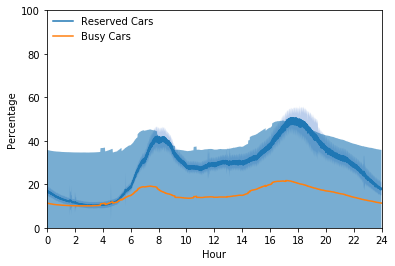

In [83]:

# Plot da media das porcentagens dos dias de semana
fig, ax = plt.subplots()
# Curva dos carros andando
ax.plot(range(len(mediaWeekdays['time'])),mediaWeekdays['mean'], label='Reserved Cars')

# Curvas representando o intervalo de desvio padrão
ax.fill_between(range(len(mediaWeekdays['time'])),mediaWeekdays['mean']+mediaWeekdays['std'], 
                mediaWeekdays['mean']-mediaWeekdays['std'], facecolor='#8faee0', alpha=0.6)

plt.plot(range(len(weekdays_travels_mean['time'])),weekdays_travels_mean['mean'], label='Busy Cars')

# Curvas representando o intervalo de desvio padrão
plt.fill_between(range(len(weekdays_travels_mean['time'])),weekdays_travels_mean['mean']+weekdays_travels_mean['std'], 
                weekdays_travels_mean['mean']-weekdays_travels_mean['std'], alpha=0.6)


# Modificando os labels das horas
ax.xaxis.set_ticks(np.arange(0, 1441, 120))

fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = range(0,26,2)

ax.set_xticklabels(labels)

# Y axis between 0%-100%
ax.set_ylim([0,100])

ax.set_xlim([0,1441])

# Legendas e label dos eixos
plt.legend(loc=2, borderaxespad=0.2, frameon=False)
plt.ylabel('Percentage')
plt.xlabel('Hour')

# Salvando o plot
# plt.savefig('../Weekdays_test.pdf', bbox_inches='tight')

plt.show()

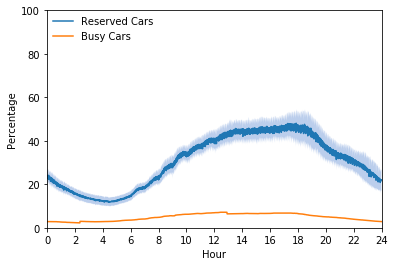

In [72]:

# Plot da media das porcentagens dos dias de semana
fig, ax = plt.subplots()
# Curva dos carros andando
ax.plot(range(len(mediaWeekends['time'])),mediaWeekends['mean'], label='Reserved Cars')

# Curvas representando o intervalo de desvio padrão
ax.fill_between(range(len(mediaWeekends['time'])),mediaWeekends['mean']+mediaWeekends['std'], 
                mediaWeekends['mean']-mediaWeekends['std'], facecolor='#8faee0', alpha=0.6)

plt.plot(range(len(weekends_travels_mean['time'])),weekends_travels_mean['mean'], label='Busy Cars')


# Modificando os labels das horas
ax.xaxis.set_ticks(np.arange(0, 1441, 120))

fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = range(0,26,2)

ax.set_xticklabels(labels)

# Y axis between 0%-100%
ax.set_ylim([0,100])

ax.set_xlim([0,1441])

# Legendas e label dos eixos
plt.legend(loc=2, borderaxespad=0.2, frameon=False)
plt.ylabel('Percentage')
plt.xlabel('Hour')

# Salvando o plot
# plt.savefig('../Weekends_test.pdf', bbox_inches='tight')

plt.show()

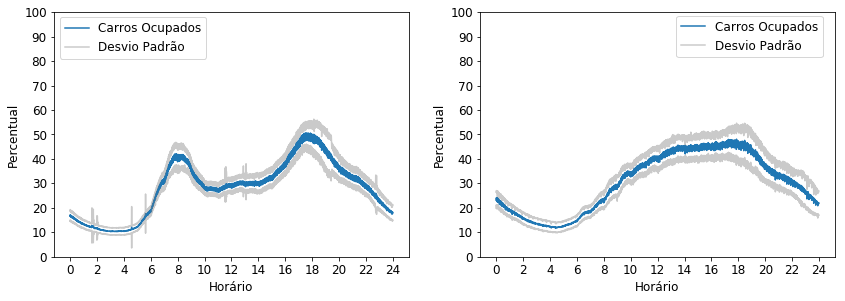

<Figure size 432x288 with 0 Axes>

In [16]:

matplotlib.rc('font', size=12)

# Plot das porcentagens dos fins de semana
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_size_inches(14,4.5)



# Curva dos carros andando

ax1.plot(range(len(mediaWeekdays['time'])),mediaWeekdays['mean'], label='Carros Ocupados')

# Curvas representando o intervalo de desvio padrão
ax1.plot(range(len(mediaWeekdays['time'])), mediaWeekdays['mean']+mediaWeekdays['std'], alpha=150, c='gray', label='Desvio Padrão')
ax1.plot(range(len(mediaWeekdays['time'])), mediaWeekdays['mean']-mediaWeekdays['std'], alpha=150, c='gray')

# Modificando os labels das horas e das porcentagens
ax1.xaxis.set_ticks(np.arange(0, 1441, 120))
ax1.yaxis.set_ticks(np.arange(0, 110, 10))

fig.canvas.draw()

labels = [item.get_text() for item in ax1.get_xticklabels()]
labels = range(0,26,2)

ax1.set_xticklabels(labels)

# Eixo y de 0 a 100%
ax1.set_ylim([0,100])

# Legendas e label dos eixos
ax1.legend(bbox_to_anchor=(0.01, 0.99), loc=2, borderaxespad=0.2)
ax1.set_ylabel('Percentual')
ax1.set_xlabel('Horário')




# # Curva dos carros andando
ax2.plot(range(len(mediaWeekends['time'])),mediaWeekends['mean'], label='Carros Ocupados')

# # Curvas representando o intervalo de desvio padrão
ax2.plot(range(len(mediaWeekends['time'])), mediaWeekends['mean']+mediaWeekends['std'], alpha=150, c='gray', label='Desvio Padrão')
ax2.plot(range(len(mediaWeekends['time'])), mediaWeekends['mean']-mediaWeekends['std'], alpha=150, c='gray')

# Modificando os labels das horas e das porcentagens
ax2.xaxis.set_ticks(np.arange(0, 1441, 120))
ax2.yaxis.set_ticks(np.arange(0, 110, 10))

fig.canvas.draw()

labels = [item.get_text() for item in ax2.get_xticklabels()]
labels = range(0,26,2)

ax2.set_xticklabels(labels)

# Eixo y de 0 a 100%
ax2.set_ylim([0,100])

# Legendas e label dos eixos
ax2.legend(bbox_to_anchor=(0.55, 0.99), loc=2, borderaxespad=0.1)
ax2.set_ylabel('Percentual')
ax2.set_xlabel('Horário')


plt.show()
plt.savefig('../plots/ViagensPorHoras_Evo.pdf')